In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotnine import *
import matplotlib.pyplot as plt



In [2]:
def box_plt(df):
    fig, axs = plt.subplots(4, 5, figsize=(20, 20))
    for i, col in enumerate(df.columns):
        ax = axs[i // 5, i % 5]  # 获取当前子图的坐标
        ax.boxplot(data[col])  # 绘制箱线图
        ax.set_title(col)  # 设置子图标题
    plt.tight_layout()  # 调整子图布局
    plt.show()  # 显示图形

In [174]:
data = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
data.dropna(inplace=True)
print(data.columns)
data_without_time = data.drop(columns=['time'])
data_without_time = data_without_time[['count', 'aqi', 'pm2_5', 'open4', 'open94','price']]

        
print(data_without_time.shape)


data_temp = data[['time','price']]
data_temp = data_temp.set_index('time')
print(data_temp)

Index(['time', 'count', 'aqi', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
       'complexindex', 'temp', 'humi', 'windlevel', 'open4', 'close4',
       'open94', 'close94', 'price'],
      dtype='object')
(745, 6)
             price
time              
2023-12-22  111.38
2023-12-19  112.00
2023-12-13   72.00
2023-12-12   72.00
2023-12-11  116.00
...            ...
2020-02-18   84.50
2020-01-09   84.50
2020-01-08   80.10
2020-01-07   76.20
2020-01-06   73.10

[745 rows x 1 columns]


In [132]:
from sklearn.ensemble import IsolationForest


def iso_tree(df):
    iso = IsolationForest(random_state=1, contamination='auto')
    preds = iso.fit_predict(df.values)
    data_without_time['cluster'] = preds
    print(data_without_time['cluster'].value_counts().sort_values(ascending=False))
    cleaned_data = df[df['cluster'] != -1].drop(columns=['cluster'])
    print("处理后的数据框形状：", cleaned_data.shape)
    return cleaned_data

data_clean = iso_tree(data_without_time)
print(data_clean.shape)


cluster
 1    640
-1    105
Name: count, dtype: int64
处理后的数据框形状： (640, 6)
(640, 6)


In [168]:
from sklearn.preprocessing import MinMaxScaler
data_clean = data_without_time
# 划分训练集和测试集
train_size = int(len(data_clean) * 0.9)
train_data = data_clean[:train_size]
test_data = data_clean[train_size:]
data_clean.reset_index(drop=True, inplace=True)
feature_columns = train_data.columns[:-1]  # 特征列为前16列
target_column = train_data.columns[-1]     # 目标列为最后一列

test_Y_ori = test_data['price']


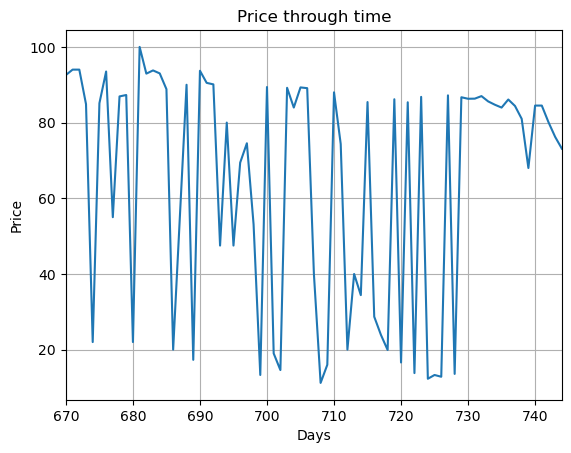

In [158]:
plt.title('Price through time')
plt.ylabel('Price')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(test_data['price'])

In [88]:

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.fit_transform(test_data)
print(train_data_normalized)

[[-0.99916154 -0.71428571 -0.67857143 ... -0.97142382 -0.96023131
   0.43585963]
 [-0.96664445 -0.85714286 -0.66071429 ... -1.         -1.
   0.44500147]
 [-0.99463602 -0.29761905  0.01785714 ... -0.93264662 -0.94552409
  -0.14479505]
 ...
 [-0.92170099 -0.05952381 -0.46428571 ... -0.79156006 -0.82343938
   0.24122678]
 [-0.99141119 -0.60714286 -0.42857143 ... -0.79455059 -0.80041646
  -0.83780596]
 [-0.93013931 -0.60714286 -0.42857143 ... -0.79455059 -0.80041646
   0.14789148]]


In [169]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假设您已经定义了 train_data 和 test_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)  # 使用训练数据来拟合缩放器
train_data_normalized = scaler.transform(train_data)
test_data_normalized = scaler.transform(test_data)  # 使用同一个缩放器来转换测试数据


# 定义滑动窗口大小
look_back = 2

# 创建数据集
def create_dataset(dataset, look_back):
    data_X, data_Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :-1]  # 特征值
        data_X.append(a)
        data_Y.append(dataset[i + look_back, -1])  # 预测的值
    return np.array(data_X), np.array(data_Y)

# 划分特征和目标
train_X, train_Y = create_dataset(train_data_normalized, look_back)
test_X, test_Y = create_dataset(test_data_normalized, look_back)

print(len(test_data_normalized))
print(train_X.shape)
print(test_X.shape)

print(test_Y.shape)


75
(668, 2, 5)
(73, 2, 5)
(73,)


In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 假设您已经准备好了 X_train 和 y_train 数据

# 定义模型
lstm_model = Sequential()

# 添加LSTM层
lstm_model.add(LSTM(7, input_shape=(look_back, 5), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))

# 添加输出层
lstm_model.add(Dense(1))

# 编译模型
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# 设置早停
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

# 拟合模型
history_lstm_model = lstm_model.fit(train_X, train_Y, epochs=300, batch_size=7, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/300
96/96 [==============================] - 2s 2ms/step - loss: 0.2185
Epoch 2/300
96/96 [==============================] - 0s 2ms/step - loss: 0.2023
Epoch 3/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1943
Epoch 4/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1850
Epoch 5/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1745
Epoch 6/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1696
Epoch 7/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1655
Epoch 8/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1628
Epoch 9/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1611
Epoch 10/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1599
Epoch 11/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1590
Epoch 12/300
96/96 [==============================] - 0s 2ms/step - loss: 0.1582
Epoch 13/300
96/96 [=================

In [171]:
from sklearn.metrics import r2_score

# 使用训练好的模型对测试集进行预测
y_pred = lstm_model.predict(test_X)
y_pred_test_lstm = lstm_model.predict(test_X)

y_train_pred_lstm = lstm_model.predict(train_X)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_Y, y_train_pred_lstm)))

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_Y  , y_pred_test_lstm)))
# 将预测结果反归一化
# y_pred_unscaled = scaler.inverse_transform(np.concatenate((test_X[:, -1], y_pred), axis=1))[:, -1]
# 将测试集目标数据反归一化
# test_Y_unscaled = scaler.inverse_transform(test_Y).flatten()[:,-1]

# 打印反归一化后的测试集目标数据
# print(test_Y_unscaled)

# print(y_pred_unscaled)
# print(y_pred_unscaled)
# print(test_Y_ori)
# print(test_Y_ori)
# 将预测结果和实际目标进行比较
# for i in range(len(y_pred)):
#     print("实际值:", test_Y[i], "预测值:", y_pred[i])


21/21 [==============================] - 0s 1ms/step
The R2 score on the Train set is:	0.356
The R2 score on the Test set is:	-1.785


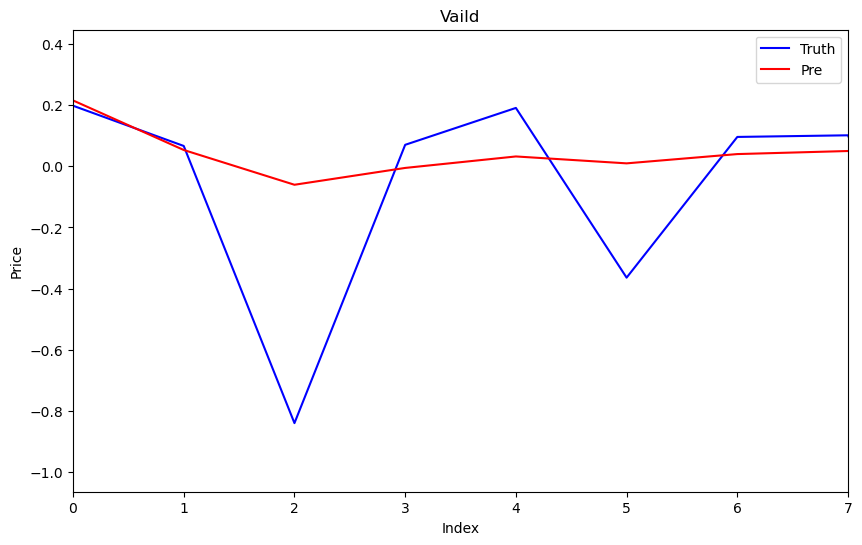

In [173]:
# 创建一个图形
plt.figure(figsize=(10, 6))

# 绘制真实值的折线图
plt.plot(test_Y, label='Truth', color='blue')

# 绘制预测值的折线图
plt.plot(y_pred, label='Pre', color='red')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Vaild')
plt.xlabel('Index')
plt.ylabel('Price')
plt.xlim([0, 7])
# 显示图形
plt.show()

# 新的一部分

In [182]:
data = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
data.dropna(inplace=True)
data_temp = data[['time','price']]
data_temp = data_temp.set_index('time', drop=True)
print(data_temp)

data_temp.index = pd.to_datetime(data_temp.index)
# 假设 df 是您的 DataFrame，其中日期时间索引为 'datetime_index'
df = data_temp.sort_index(ascending=True)

# 打印排序后的 DataFrame
print(df)


             price
time              
2023-12-22  111.38
2023-12-19  112.00
2023-12-13   72.00
2023-12-12   72.00
2023-12-11  116.00
...            ...
2020-02-18   84.50
2020-01-09   84.50
2020-01-08   80.10
2020-01-07   76.20
2020-01-06   73.10

[745 rows x 1 columns]
             price
time              
2020-01-06   73.10
2020-01-07   76.20
2020-01-08   80.10
2020-01-09   84.50
2020-02-18   84.50
...            ...
2023-12-11  116.00
2023-12-12   72.00
2023-12-13   72.00
2023-12-19  112.00
2023-12-22  111.38

[745 rows x 1 columns]


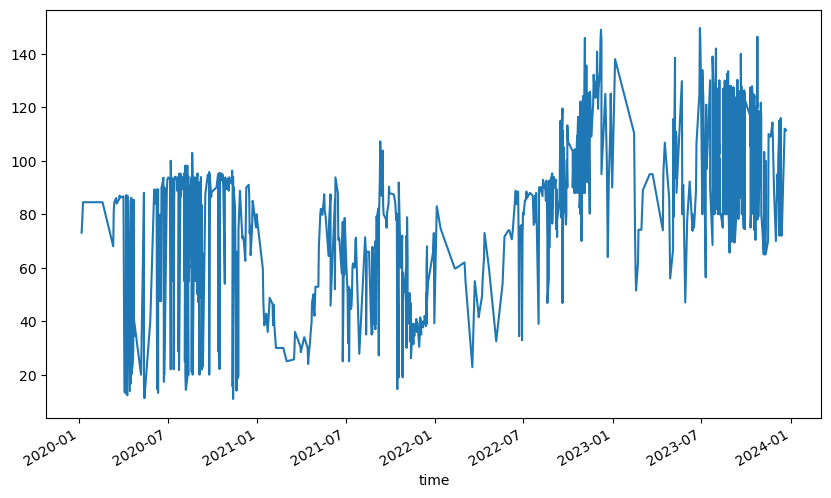

In [183]:
plt.figure(figsize=(10, 6))

df['price'].plot();

<class 'pandas.core.series.Series'>


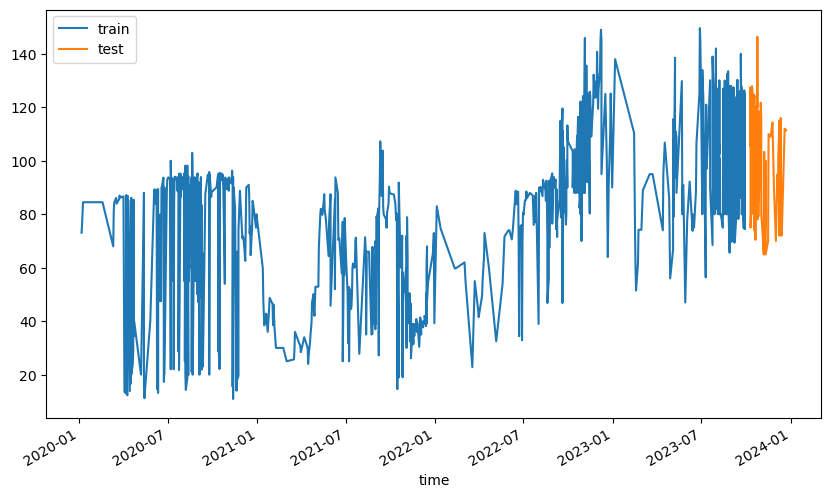

In [199]:
split_date = pd.Timestamp('2023-10-01')

df_data=  df['price']
print(type(df_data))

train = df_data.loc[:split_date]

test = df_data.loc[split_date:]

plt.figure(figsize=(10, 6))

ax = train.plot()

test.plot(ax=ax)

plt.legend(['train', 'test']);

In [249]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# 输入序列(t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# 预测序列(t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# 把所有放在一起
	agg = concat(cols, axis=1)
	agg.columns = names
	# 删除空值行
	if dropnan:
		agg.dropna(inplace=True)
	return agg

df = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
df = df.drop(columns='time')
values = df.values
values = values.astype('float32')

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[17, 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]], axis=1, inplace=True)
print(reframed.head(3))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       79.0       43.0       18.0       38.0        0.4       34.0   
2     3104.0       31.0       19.0       31.0        0.4       19.0   
3      130.0      107.0       80.0       98.0        1.3       45.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        2.0    2.04048      -9.096      45.458       1.542   
2        0.0        2.0    1.59405      -8.942      40.500       3.375   
3       14.0        2.0    5.25655      -2.146      83.583       1.875   

    var13(t-1)   var14(t-1)   var15(t-1)   var16(t-1)  var17(t-1)  var17(t)  
1  2650.298096  2648.003906  1770.880005  1804.130005  111.379997     112.0  
2  2650.077881  2656.137939  1727.880005  1745.020020  112.000000      72.0  
3  2721.874023  2692.917969  1818.589966  1778.930054   72.000000      72.0  


In [279]:
# def create_dataset(dataset, look_back):
# #这里的look_back与timestep相同
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back)]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back])
#     return np.array(dataX),np.array(dataY)
# 
# look_back = 2
# X_train,y_train  = create_dataset(train_sc,look_back)
# X_test,y_test=create_dataset(test_sc,look_back)

scaler = MinMaxScaler(feature_range=(0, 1))

values = reframed.values
values = scaler.fit_transform(values)
n_train_hours = int(len(values)*0.9)
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# scaler = MinMaxScaler(feature_range=(0, 1))
# test = scaler.fit_transform(test)

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X  = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

668
(668, 1, 17) (668,) (75, 1, 17) (75,)


In [280]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
class LSTMmodel:
    def __init__(self, input_shape, units=100):
        self.input_shape = input_shape
        self.units = units
        self.model = self.build_model(input_shape)
    
    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=input_shape))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        return model
        
    def train(self, train_x, train_y, epochs=50, batch_size=32):
        self.model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size)
        
    def predict(self, X, verbose):
        return self.model.predict(X, verbose=verbose)
	


LSTM_model = LSTMmodel(input_shape=train_X.shape[1:], units=100) 
LSTM_model.train(train_X, train_y, epochs=100, batch_size=32)


Epoch 1/100
21/21 [==============================] - 2s 2ms/step - loss: 0.2664
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1913
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1730
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1632
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1555
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1488
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1458
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1431
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1415
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1404
Epoch 11/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1389
Epoch 12/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1393
Epoch 13/100
21/21 [=================

3/3 [==============================] - 1s 6ms/step


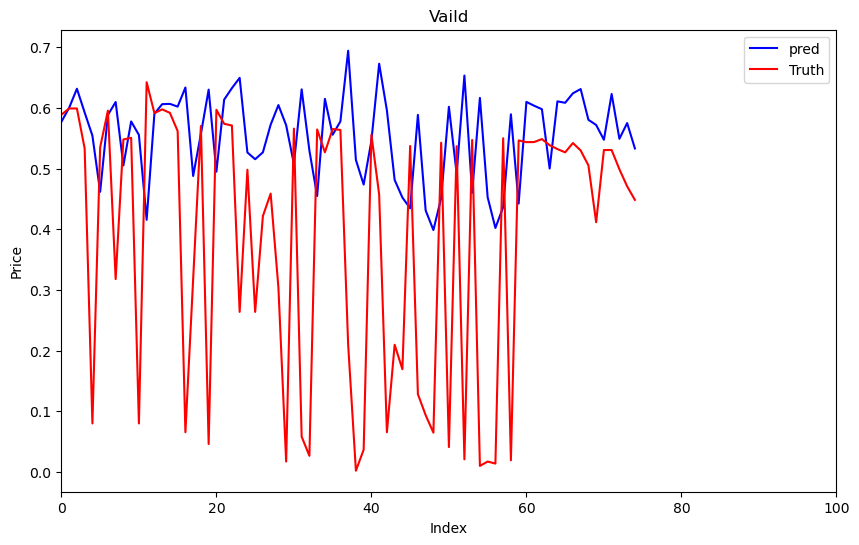

In [281]:
pred_x = LSTM_model.predict(test_X, verbose=1)

test_y1= test_y.reshape(-1,1)
# 
# x_temp = np.concatenate((test_X, pred_x), axis=1)
# y_temp = np.concatenate((test_X, test_y), axis=1)
# pred_x = scaler.inverse_transform(pred_x)
# test_y = scaler.inverse_transform(test_y)
plt.figure(figsize=(10, 6))

# 绘制真实值的折线图
plt.plot(pred_x, label='pred', color='blue')

# 绘制预测值的折线图
plt.plot(test_y, label='Truth', color='red')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Vaild')
plt.xlabel('Index')
plt.ylabel('Price')
plt.xlim(0, 100)
# 显示图形
plt.show()

In [206]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

lstm_model = Sequential()

lstm_model.add(LSTM(7, input_shape=(2, X_train.shape[2]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=True))
# 添加第二个LSTM层
lstm_model.add(LSTM(7, activation='relu', kernel_initializer='lecun_uniform'))

lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=4, verbose=1)

history_lstm_model = lstm_model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/300
679/679 [==============================] - 3s 2ms/step - loss: 0.1440
Epoch 2/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1196
Epoch 3/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1177
Epoch 4/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1177
Epoch 5/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1174
Epoch 6/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1171
Epoch 7/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1169
Epoch 8/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1166
Epoch 9/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1163
Epoch 10/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1160
Epoch 11/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1158
Epoch 12/300
679/679 [==============================] - 2s 2ms/step - loss: 0.1154
Epoch 13/300


In [284]:
y_pred_test_lstm = LSTM_model.predict(test_X, verbose=1)

y_train_pred_lstm = LSTM_model.predict(train_X, verbose=1)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, y_train_pred_lstm)))

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, y_pred_test_lstm)))

21/21 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.381
The R2 score on the Test set is:	-0.671


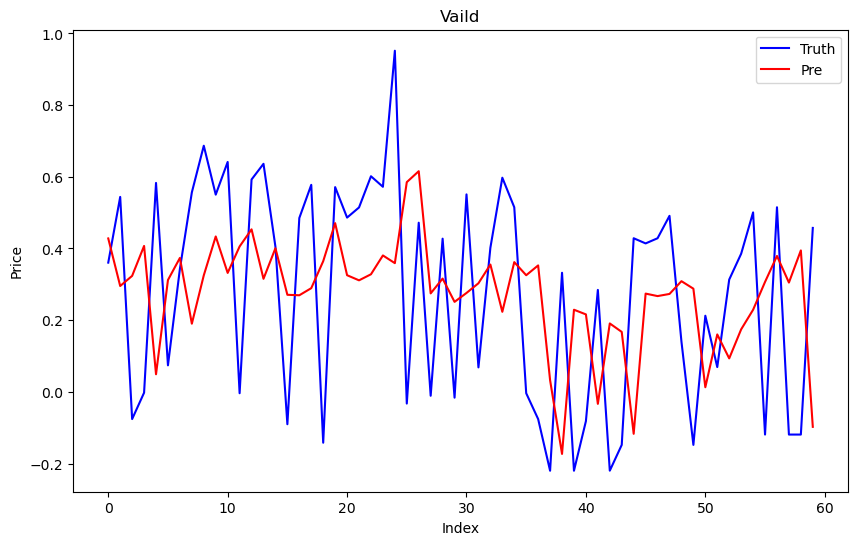

In [209]:
plt.figure(figsize=(10, 6))

# 绘制真实值的折线图
plt.plot(y_test, label='Truth', color='blue')

# 绘制预测值的折线图
plt.plot(y_pred_test_lstm, label='Pre', color='red')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Vaild')
plt.xlabel('Index')
plt.ylabel('Price')

# 显示图形
plt.show()
